In [27]:
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

save_path = "..\\..\\Report\\LaTeX\\04-resources\\implementation\\"

## Open the image and displays it

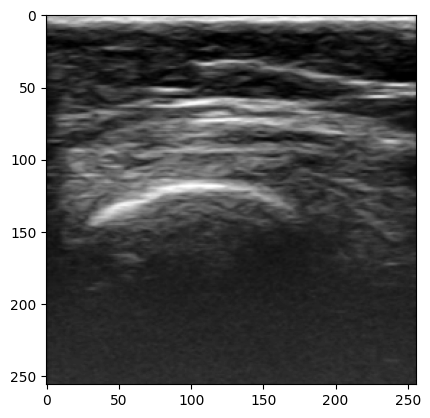

In [28]:
img_path = "../../Data/Images_set_resized//3DUS_L_probe1_conf1_ds1.dcm_p300.jpg"
img = cv2.imread(img_path, 0)
# img = cv2.imread("example.png", 0)
DIM = 256
img = cv2.resize(img, (DIM,DIM))
plt.imshow(img, cmap='gray')

## Apply a Gaussian filter

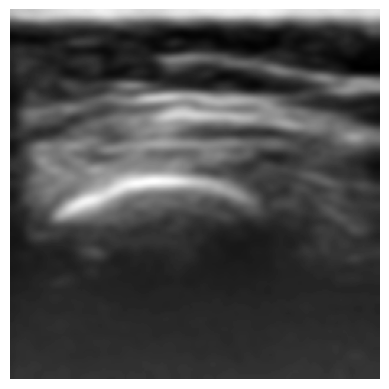

True

In [29]:
ksize = 15
blur = cv2.GaussianBlur(img,(ksize,ksize),0)
plt.imshow(blur, cmap='gray')
plt.axis('off')
plt.show()
cv2.imwrite(save_path + "gaussien_filter.png", blur*256)

## Apply a threshold on the blurred image

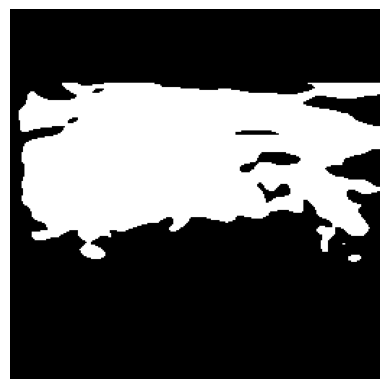

True

In [30]:
threshold = 0.2
ret,thresh = cv2.threshold(blur,round(threshold*255),1,cv2.THRESH_BINARY)

# Remove the top layer
proportion = 0.2
height = round(proportion * img.shape[0])
thresh[:height] = 0
thresh = thresh.astype(np.float64)

plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.show()
cv2.imwrite(save_path + "threshold.png", thresh*256)

## Apply a Laplacian of Gaussian (LoG)

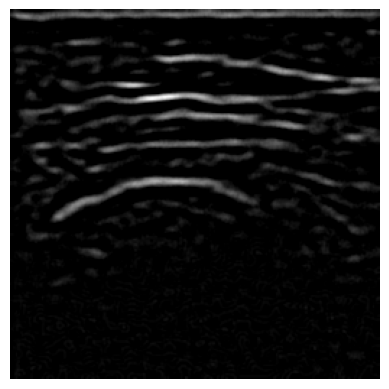

True

In [31]:
laplacian = cv2.Laplacian(blur, ddepth=cv2.CV_16S, ksize=5)

# Only keep the negative pixels
laplacian = -laplacian
laplacian = laplacian / np.max(laplacian)
laplacian = np.clip(laplacian, 0, 1)

plt.imshow(laplacian, cmap='gray')
plt.axis('off')
plt.show()
cv2.imwrite(save_path + "LoG.png", laplacian*256)

## Shadow model

$\operatorname{Shadow}(a, b)=\frac{\sum_{j=a}^R G(j-a) I(j, b)}{\sum_{j=a}^R G(j-a)}$

In [32]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def shadow_value(img, mu=0, sigma=40):
    shadow_img = np.zeros(img.shape)
    R, C = img.shape
    G = np.tile(gaussian(np.arange(R), mu, sigma), (C, 1)).T
    for a in range(R):
        I = img[a:]
        # Compute the numerator and denominator of the shadow formula
        numerator = np.sum(G[:R-a] * I, axis=0)
        denominator = np.sum(G[:R-a], axis=0)
        
        # Compute the shadow value and return it
        shadow_line = numerator / denominator
        shadow_img[a] = shadow_line
                
    return shadow_img

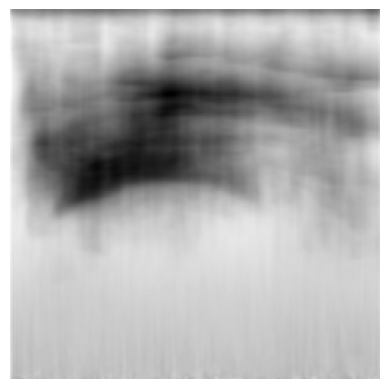

True

In [33]:
shadow_image = shadow_value(img, sigma=20)
shadow_image = shadow_image / np.max(shadow_image)
shadow_image = 1 - shadow_image
plt.imshow(shadow_image, cmap='gray')
plt.axis('off')
plt.show()
cv2.imwrite(save_path + "shadow_model.png", shadow_image*256)

## Log-Gabor filter

In [34]:
number_scales = 5          # scale resolution
number_orientations = 8    # orientation resolution
N = 256                    # image dimensions
def getFilter(f_0, theta_0):
    # filter configuration
    scale_bandwidth =  0.996 * math.sqrt(2/3)
    angle_bandwidth =  0.996 * (1/math.sqrt(2)) * (np.pi/number_orientations)

    # x,y grid
    extent = np.arange(-N/2, N/2 + N%2)
    x, y = np.meshgrid(extent,extent)

    mid = int(N/2)
    ## orientation component ##
    theta = np.arctan2(y,x)
    center_angle = ((np.pi/number_orientations) * theta_0) if (f_0 % 2) \
                else ((np.pi/number_orientations) * (theta_0+0.5))

    # calculate (theta-center_theta), we calculate cos(theta-center_theta) 
    # and sin(theta-center_theta) then use atan to get the required value,
    # this way we can eliminate the angular distance wrap around problem
    costheta = np.cos(theta)
    sintheta = np.sin(theta)
    ds = sintheta * math.cos(center_angle) - costheta * math.sin(center_angle)    
    dc = costheta * math.cos(center_angle) + sintheta * math.sin(center_angle)  
    dtheta = np.arctan2(ds,dc)

    orientation_component =  np.exp(-0.5 * (dtheta/angle_bandwidth)**2)

    ## frequency componenet ##
    # go to polar space
    raw = np.sqrt(x**2+y**2)
    # set origin to 1 as in the log space zero is not defined
    raw[mid,mid] = 1
    # go to log space
    raw = np.log2(raw)

    center_scale = math.log2(N) - f_0
    draw = raw-center_scale
    frequency_component = np.exp(-0.5 * (draw/ scale_bandwidth)**2)

    # reset origin to zero (not needed as it is already 0?)
    frequency_component[mid,mid] = 0

    return frequency_component * orientation_component, frequency_component, orientation_component

def get_filter_bank(number_scales, number_orientations):
    filter_bank = []
    
    # Loop over orientations and scales
    for o in range(number_orientations):
        for s in range(number_scales):
            
            filter_bank.append(getFilter(s+1, o))
            
    return filter_bank
            

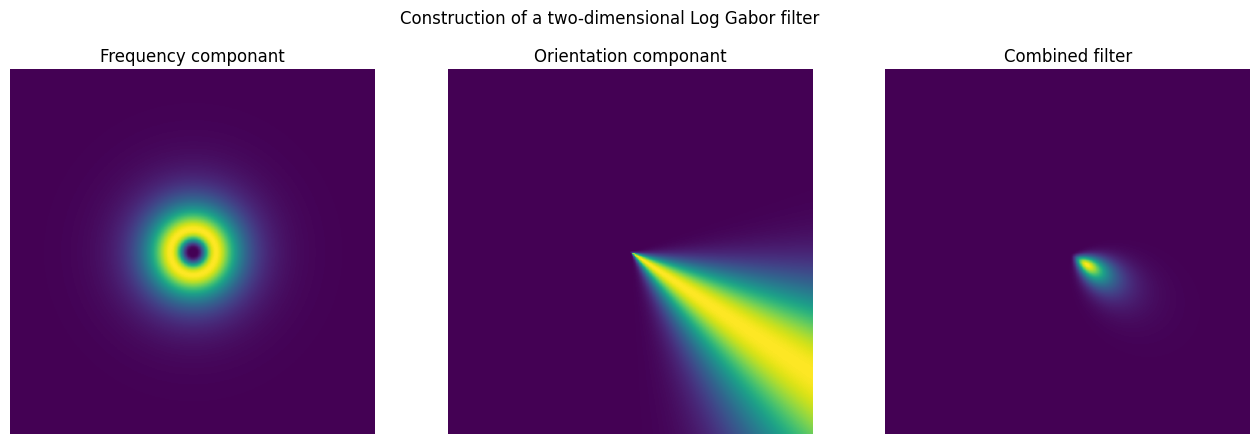

In [35]:
filter, freq_filter, orient_filter = getFilter(4, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Construction of a two-dimensional Log Gabor filter')
ax1.imshow(freq_filter)
ax1.set_title('Frequency componant')
ax1.axis('off')
ax2.imshow(orient_filter)
ax2.set_title('Orientation componant')
ax2.axis('off')
ax3.imshow(filter)
ax3.set_title('Combined filter')
ax3.axis('off')
plt.show()
fig.savefig(save_path + "log_gabor_construction.png", bbox_inches='tight')

### Generate the filter bank

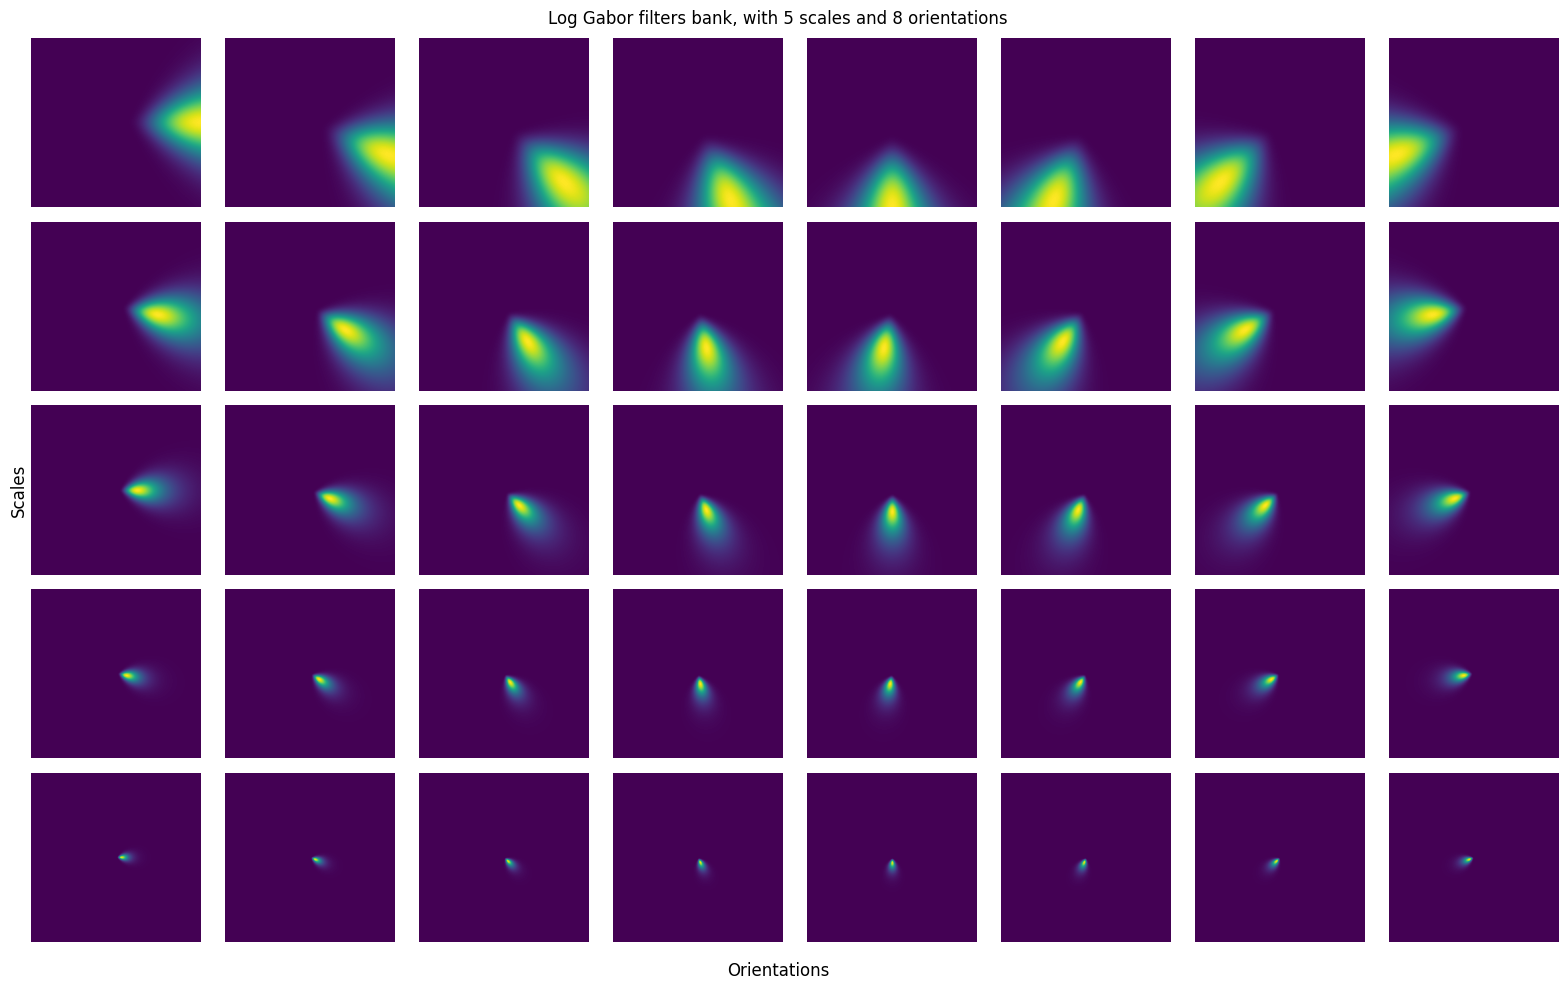

In [36]:
filters = get_filter_bank(number_scales, number_orientations)
summed_filters = np.zeros(filters[0][0].shape)

plt_img_size = 2
fig, axes = plt.subplots(number_scales, number_orientations, figsize=(number_orientations*plt_img_size, number_scales*plt_img_size))
fig.suptitle(f'Log Gabor filters bank, with {number_scales} scales and {number_orientations} orientations')
for no in range(number_orientations):
    for ns in range(number_scales):
        # ifft_filter = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(filters[no*number_scales+ns][0]))).real
        # axes[ns, no].imshow(ifft_filter)
        axes[ns, no].imshow(filters[no*number_scales+ns][0])
        axes[ns, no].axis('off')
        
        # summed_filters += filters[no*number_scales+ns][0]
fig.supxlabel('Orientations')
fig.supylabel('Scales')
fig.tight_layout()
plt.show()
fig.savefig(save_path + "log_gabor_filters_bank.png", bbox_inches='tight')

### Apply the filter bank to the image

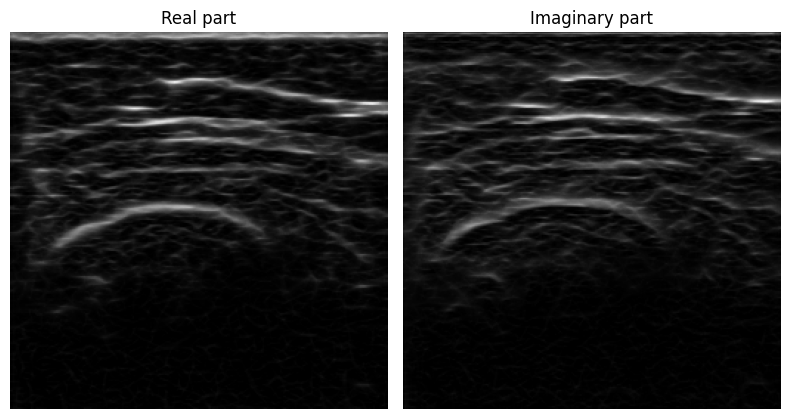

In [37]:
def apply_log_gabor_filter(img, filter):
    return np.fft.ifft2(np.fft.ifftshift((np.fft.fftshift(np.fft.fft2(img)) * np.fft.ifftshift(filter))))

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def apply_log_gabor_filter_conv(img, filter):
    ifft_filter = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(filter)))
    # k_size = 7
    # ifft_filter = cv2.resize(ifft_filter, (k_size, k_size))
    # ifft_filter = crop_center(ifft_filter, k_size, k_size)
    return cv2.filter2D(img,-1,ifft_filter.real) + cv2.filter2D(img,-1,ifft_filter.imag)*1j

def normalize(img):
    img.real = (img.real - np.amin(img.real)) / (np.amax(img.real) - np.amin(img.real))
    img.imag = (img.imag - np.amin(img.imag)) / (np.amax(img.imag) - np.amin(img.imag))
    return img

log_gabor_img = []
log_gabor_img_summed = np.zeros(img.shape, dtype=complex)
for no in range(number_orientations):
    for ns in range(number_scales):
        log_gabor_img.append(apply_log_gabor_filter_conv(img, filters[no*number_scales+ns][0]))
        log_gabor_img_summed += log_gabor_img[-1]

# Rescale the image
log_gabor_img_summed = normalize(log_gabor_img_summed)

fig, ax = plt.subplots(1,2, figsize=(8, 6))
ax[0].imshow(log_gabor_img_summed.real, cmap='gray')
ax[0].set_title('Real part')
ax[0].axis('off')
ax[1].imshow(log_gabor_img_summed.imag, cmap='gray')
ax[1].set_title('Imaginary part')
ax[1].axis('off')
fig.tight_layout()
plt.show()
fig.savefig(save_path + "log_gabor.png", bbox_inches='tight')

## Integrated backscattering

$\operatorname{IBS}(a, b)= \displaystyle\sum_{i=1}^{b} I^2(a, i)$

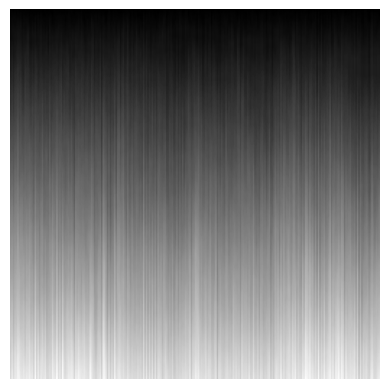

True

In [38]:
def IBS(img):
    squared_image = np.square(img)
    
    # Cumulative sum of each row
    ibs = np.cumsum(squared_image, axis=0)
        
    # Normalize between 0 and 1
    ibs = ibs / np.max(ibs)
    
    return ibs

ibs = IBS(img)
plt.imshow(ibs, cmap='gray')
plt.axis('off')
plt.show()
cv2.imwrite(save_path + "ibs.png", ibs*256)

## Final probability map

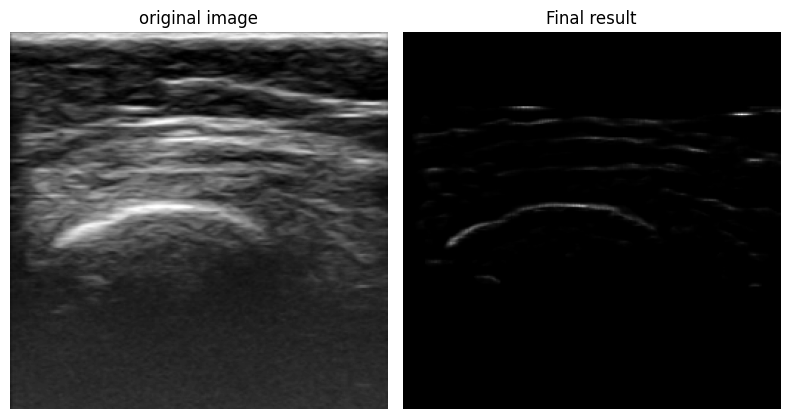

In [39]:
prob_map = laplacian * thresh * shadow_image * log_gabor_img_summed.real * log_gabor_img_summed.imag * ibs
prob_map /= np.max(prob_map)

fig, ax = plt.subplots(1,2, figsize=(8, 6))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('original image')
ax[0].axis('off')
ax[1].imshow(prob_map, cmap='gray')
ax[1].set_title('Final result')
ax[1].axis('off')
fig.tight_layout()
plt.show()
fig.savefig(save_path + "bone_probability_map.png", bbox_inches='tight')

## Keep biggest blob and trace the top segment

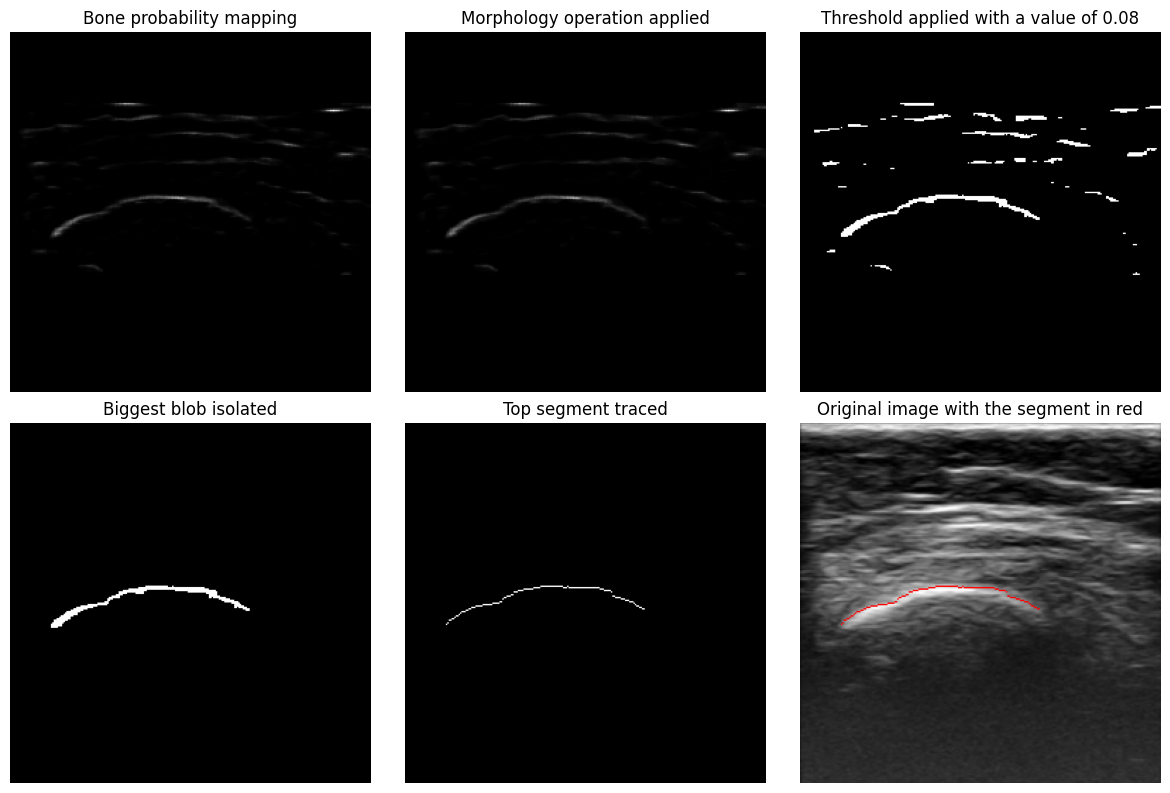

In [40]:
# Trim the values too low
threshold = 0.08
threshold_int = round(threshold*255)

# ret,img_uint = cv2.threshold(prob_map*255,threshold_int,255,cv2.THRESH_BINARY)
img_uint = (prob_map*255).astype(np.uint8)

# Generate intermediate image; use morphological closing to keep parts of the bone together
str_elem_size = 5
inter = cv2.morphologyEx(img_uint, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (str_elem_size, str_elem_size)))

ret,inter_thresh = cv2.threshold(inter,threshold_int,255,cv2.THRESH_BINARY)
inter_thresh = inter_thresh.astype(np.uint8)
# inter = cv2.bitwise_not(inter)

# Find largest contour in intermediate image
cnts, _ = cv2.findContours(inter_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Output
out = np.zeros(img_uint.shape, np.uint8)
if len(cnts) > 0:
    cnt = max(cnts, key=cv2.contourArea)
    cv2.drawContours(out, [cnt], -1, 255, cv2.FILLED)

# Only keep the top pixel of each column of the biggest blob
segment = np.zeros(prob_map.shape)
for idx, column in enumerate(out.T):
    top_pixel = np.where(column == 255)[0]
    if len(top_pixel) > 0:
        segment[top_pixel[0], idx] = 255

# Trace the segment on the original image
image_with_segment = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
image_with_segment[segment==255] = [255, 0, 0]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.flatten()
ax[0].imshow(img_uint, cmap='gray')
ax[0].set_title('Bone probability mapping')
ax[0].axis('off')
ax[1].imshow(inter, cmap='gray')
ax[1].set_title('Morphology operation applied')
ax[1].axis('off')
ax[2].imshow(inter_thresh, cmap='gray')
ax[2].set_title(f'Threshold applied with a value of {threshold}')
ax[2].axis('off')
ax[3].imshow(out, cmap='gray')
ax[3].set_title('Biggest blob isolated')
ax[3].axis('off')
ax[4].imshow(segment, cmap='gray')
ax[4].set_title('Top segment traced')
ax[4].axis('off')
ax[5].imshow(image_with_segment, cmap='gray')
ax[5].set_title('Original image with the segment in red')
ax[5].axis('off')
fig.tight_layout()
plt.show()
fig.savefig(save_path + "segment_traced.png", bbox_inches='tight')

## Print the segment on the original image

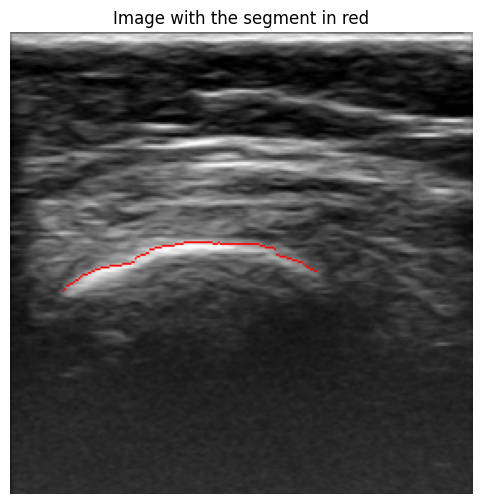

In [41]:
image_with_segment = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
image_with_segment[segment==255] = [255, 0, 0]

fig = plt.figure(figsize=(12, 6))
fig.tight_layout()
plt.axis('off')
plt.title('Image with the segment in red')
plt.imshow(image_with_segment)

# Bone Localization Optimization

$E_{\text {int }}(i, j)=\left\{\begin{array}{lc}\alpha\left\|\frac{d S e g}{d s}\right\|^2+\beta\left\|\frac{d^2 \operatorname{Seg}}{d s^2}\right\|^2+\gamma & \text { Bone region } \\ \text { JumpCost } & \text { Jump region }\\ \alpha D_1^2+\beta D_2^2 & \text { Boneless region }\end{array}\right.$

Not working yet. Will be finished during the thesis.

In [42]:
E_ext = 1 - prob_map
seg_min = np.zeros(prob_map.shape)
idx_min = np.zeros(prob_map.shape)
E_int = np.zeros(prob_map.shape)
rows, columns = prob_map.shape

def internal_energy(k, j, threshold=0.15, alpha=0.1, beta=0.1, gamma=-0.1, jump_cost=5, D_1=1, D_2=1):
    '''
    Compute the internal energy of the pixel
    '''
    
    pixel = prob_map[k, j]
    # First, check if the pixel if a bone. It's value must be abore the threshold.
    bone = pixel >= threshold
    
    # Get the two previous segment points, to compute the derivatives.
    prev_pixel = 0
    prev_pixel_2 = 0
    if j > 0:
        prev_index = idx_min[k, j]
        prev_pixel = get_min_row(j-1)
    if j > 1:
        prev_pixel_2 = get_min_row(j-2)
    
    # Compute the internal energy
    ...
    
    return

def get_min_row(j):
    # First, compute the internal energy of the column
    for k in range(rows):
        E_int[k, j] = internal_energy(k, j)
        
    # Then, add the internal energy to the seg_min of the previous column
    min_column = E_int[:, j]
    if j > 0:
        min_column += seg_min[:, j-1]
        
    # Get the minimum value and index of this column
    min_value = np.amin(min_column, axis=1)
    min_idx = np.argmin(min_column, axis=1)
    
    # Assign the column of minimum indexes
    idx_min[:,j] = min_idx
    
    # Return the minimum value
    return min_value

def compute_seg_min():
    for j in range(columns):
        min_row = get_min_row(j)
        for i in range(rows):
            seg_min[i, j] = E_ext[i, j] + min_row
            
    

In [43]:
# def define_regions(img, threshold):
#     '''
#     This function defines the part of the images that are bone of boneless, using a threshold value.
    
#     Return: A vector representing if the column are bone of boneless. True means bone, False means boneless.
#     '''
#     bone_presence = img.max(axis=0) >= threshold
#     #TODO: Add jump cost
#     return bone_presence

# image_portions = define_regions(prob_map, 0.15)